## **ML-Model to detect gender age based on his/her voice**   
In this notebook, I am using a common-voice dataset to train a model for detecting age of 
a person based on his/her voice

### **Stepwise ML-model development**  
This notebook is created for beginners to develop age detection ml-model with stepwise approach using common-voice dataset.
The notebook include following steps:
* Data Collection
* Data Pre-processing 
* Feature Engineering
* Model Selection
* Model Analysis
* Model Deployment

### **Step-01 Data Collection**  
In this step the data is loaded and explored. The data is understood with basic graphs and to check if the dataset is balanced.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns # visualizing data with stunning default theme
import sklearn # contain algorithms
import warnings
warnings.filterwarnings('ignore')

# load dataset from input directory
df = pd.read_csv("../input/common-voice/cv-valid-train.csv") 
df[df['age'].notna()].head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


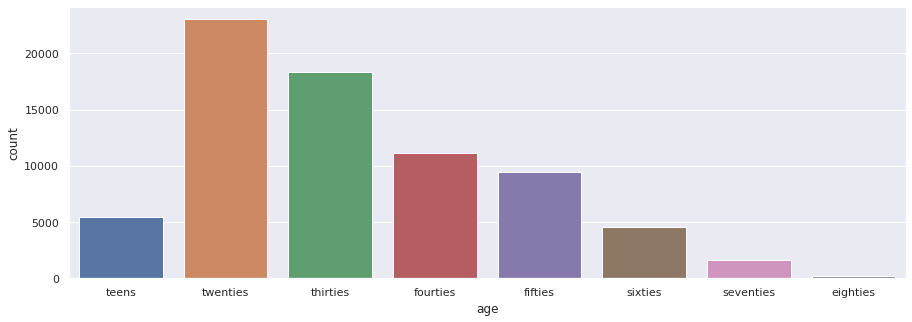

In [2]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age", 
        data=df[df['age'].notna()], 
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()


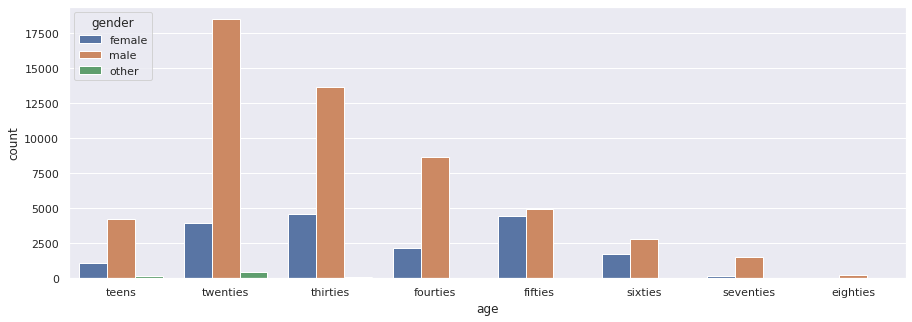

In [3]:
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

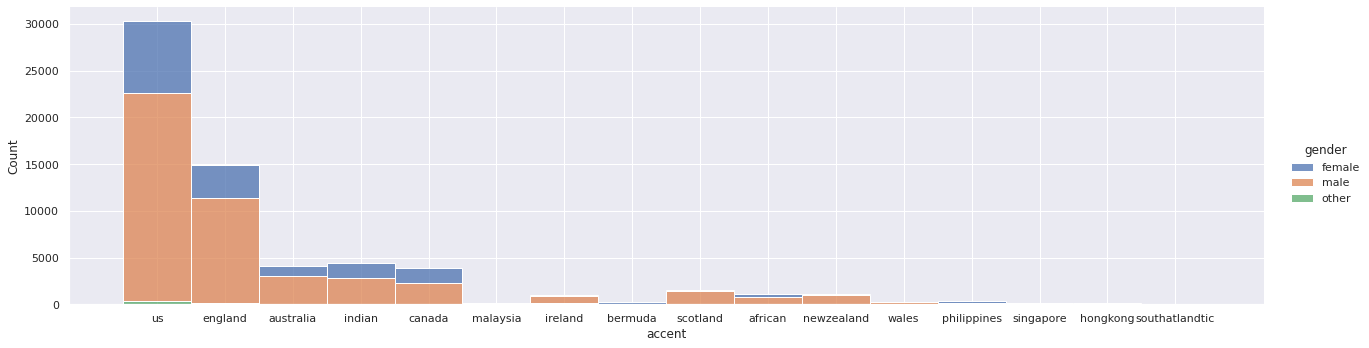

In [4]:
sns.displot(x="accent", 
        data=df[df['accent'].notna()], 
        hue='gender',
        multiple='stack',
        height=5, aspect=18/5)

plt.show()

initial: (195776, 8) final: (63163, 8)


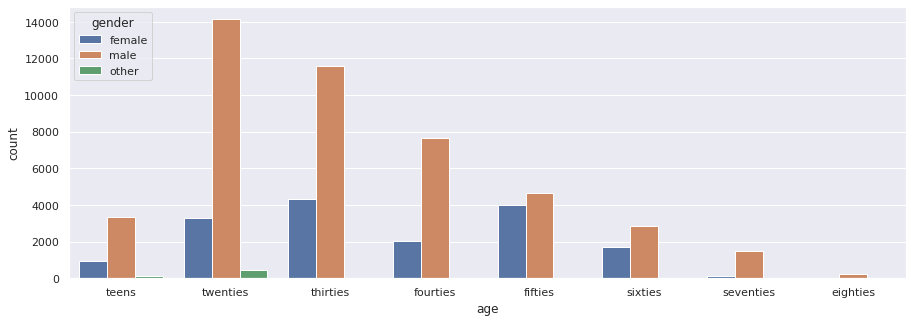

In [5]:
#del df['duration']
start=df.shape
#df.isna().sum()
end = df[df['age'].notna()& df['gender'].notna() & df['accent'].notna()].shape
print("initial: {} final: {}".format(start, end))
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()& df['gender'].notna() & df['accent'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

#### **First-step findings**
We understood the dataset and also found that the dataset is imbalance. To refine the dataset for ml-model, we need to perform pre-processing in next-step.

### Data Pre-processing  
#### Data Cleaning  
In this step we drop entries(samples) with NaN values. The columns that doesn't contribute(unnecessary) to the model are removed. The attributes are checked for its datatypes and changed to an approapriate type.

In [6]:
#we extract the columns that we think useful are
df = df[['filename','age','gender']]
#To clean the data we remove the sample with NaN attribute values.
data = df[df['age'].notna() & df['gender'].notna()]
data.reset_index(inplace=True, drop=True)
data.head()

# import pandas as pd
# import random

# # Assuming you already have a DataFrame 'df' with columns 'filename', 'age', and 'gender'
# # Extract the columns you want to keep
# df = df[['filename', 'age', 'gender']]

# # To clean the data, remove samples with NaN attribute values
# data = df[df['age'].notna() & df['gender'].notna()]

# # Reset the index after filtering
# data.reset_index(inplace=True, drop=True)

# # Shuffle the data randomly
# data = data.sample(frac=1, random_state=42)  # 'frac=1' shuffles all rows

# # Reset the index again after shuffling
# data.reset_index(inplace=True, drop=True)

# data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female
3,cv-valid-train/sample-000014.mp3,sixties,male
4,cv-valid-train/sample-000019.mp3,fifties,male


In [7]:
#data['gender'] = pd.to_numeric(data['gender'],errors = 'coerce')
#data.dtypes
#if the below code fail to covert gender datatype and values then uncomment above code
cleanup_nums = {"gender": {"male":1,"female":0,"other":0.5}}
data = data.replace(cleanup_nums)
data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,0.0
1,cv-valid-train/sample-000008.mp3,seventies,1.0
2,cv-valid-train/sample-000013.mp3,thirties,0.0
3,cv-valid-train/sample-000014.mp3,sixties,1.0
4,cv-valid-train/sample-000019.mp3,fifties,1.0


### **Feature Engineering**
#### **Feature Extraction**

We extract the following features:  
The following features are related to audio quality through which the model will learn more effectively. In this project it is not necessary to have good knowledge about the given audio features.
**Gender**
* **Spectral Centroid**: each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame
* **Spectral Bandwidth**: compute 2nd-order spectral bandwidth
* **Spectral Rolloff**: the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below
* **Mel Frequency Cepstral Coefficients (MFCCs)**: a small set of 20 features that describe the overall shape of a spectral envelope

**Librosa package**  
Librosa is a Python package for music and audio analysis. It provides the building blocks necessary to create the music information retrieval systems. Librosa helps to visualize the audio signals and also do the feature extractions in it using different signal processing techniques.

In [8]:
import librosa
ds_path = "/kaggle/input/common-voice/cv-valid-train/"

#this function is used to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
        
features = feature_extraction(data.iloc[0]['filename'])
print("features: ", features)

features:  [0.0, 2679.9395691628692, 3347.669488765762, 5745.486745886655, -625.21814, 111.32094, 6.3269944, 34.757614, 31.619902, -4.714646, -0.48603064, -4.9340243, -12.714733, -2.0551484, -3.7411177, -10.702963, -11.202637, -12.003523, -8.48958, -5.463276, -4.9542165, -3.7151983, -6.3305287, -6.3384743]


In [10]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 50001
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "label"])

df_features = create_df_features(data)
df_features.head()

50000/73465

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.0,2679.939569,3347.669489,5745.486746,-625.218140,111.320938,6.326994,34.757614,31.619902,-4.714646,...,-10.702963,-11.202637,-12.003523,-8.489580,-5.463276,-4.954216,-3.715198,-6.330529,-6.338474,twenties
1,1.0,2859.467798,2576.661658,4912.241181,-469.897675,126.299873,-16.546749,3.553606,2.178288,13.770478,...,-10.987108,1.146530,6.103549,-1.724739,-1.226475,-6.429199,-7.261915,-4.788061,-3.121077,seventies
2,0.0,1976.049163,1830.611037,3344.301008,-418.205048,147.668320,-49.972744,-2.285531,37.187012,-8.904264,...,-13.845863,-9.927490,-7.871619,-5.473860,-2.295655,-6.554991,-5.206914,-0.407431,-3.882371,thirties
3,1.0,2333.782018,2533.276030,4398.731436,-464.911224,118.436134,19.749296,27.143938,26.439018,2.309575,...,-5.458494,-2.907650,-4.495940,-2.715732,-0.079105,-5.292979,-5.866175,0.601412,-3.376775,sixties
4,1.0,2351.958974,2974.758776,4743.172457,-343.828766,157.151764,7.660183,41.900478,-15.153757,28.925409,...,0.101646,6.319596,-1.603062,3.837600,-2.643968,2.324786,-1.382977,3.790324,-3.534814,fifties


### **Feature Transformation**  

Scaling the features with the scikit-learn StandardScaler.

In [12]:
from sklearn.preprocessing import StandardScaler

def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 0:-1], dtype = float))
    # with data.iloc[:, 0:-1] we don't consider the label column
        
    return scaled_data, scaler

x, scaler = scale_features(df_features)

In [13]:
print("Before scaling:", df_features.iloc[0].values[:-1])
print("\nAfter scaling:", x[0])

Before scaling: [0.0 2679.9395691628692 3347.669488765762 5745.486745886655
 -625.2181396484375 111.32093811035156 6.3269944190979 34.75761413574219
 31.619901657104492 -4.714645862579346 -0.486030638217926
 -4.934024333953857 -12.714733123779297 -2.0551483631134033
 -3.7411177158355713 -10.702962875366211 -11.20263671875
 -12.003522872924805 -8.489580154418945 -5.463275909423828
 -4.954216480255127 -3.715198278427124 -6.330528736114502
 -6.338474273681641]

After scaling: [-1.73218658 -0.26168776  0.70886528  0.16274256 -1.99311247 -0.21142424
  0.48944029  0.77062915  1.67862847 -0.8705479   0.16520508 -0.27810844
 -1.09068651  0.46187941 -0.01898868 -1.19065798 -1.70869338 -1.33548504
 -1.18936328 -0.56353801 -0.36755184 -0.50961821 -1.03758816 -0.65001164]


In [14]:
df_features['label'].unique()


array(['twenties', 'seventies', 'thirties', 'sixties', 'fifties',
       'fourties', 'teens', 'eighties'], dtype=object)

In [15]:
from sklearn.preprocessing import LabelEncoder

def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    return labels, encoder

y, encoder = get_labels(df_features)
classes = encoder.classes_
print("Before encoding:", df_features.iloc[0].values[-1])
print("\nAfter encoding:", y[0])
print("\nClasses:", classes)

Before encoding: twenties

After encoding: 7

Classes: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']


### **Feature Selection**  

We use the ANOVA (ANalysis Of VAriance) statistical technique (f_classif) to select the best 22 features.


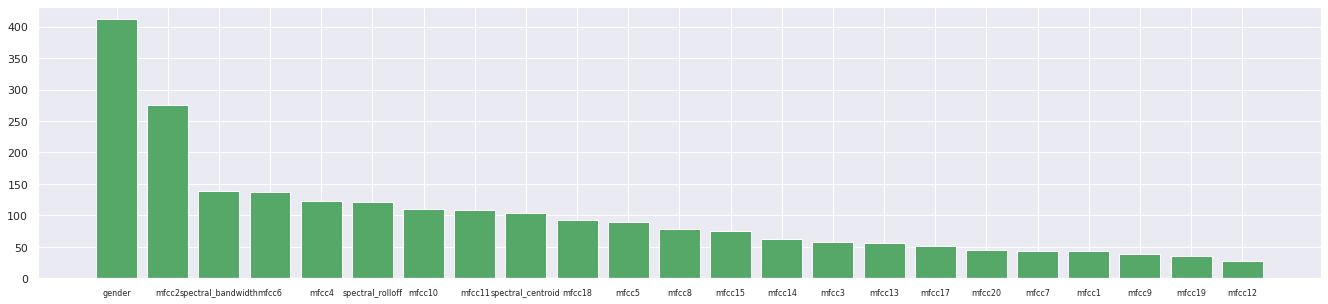

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

n_features = 23

f_selector = SelectKBest(f_classif, k=n_features).fit(x, y)
X_new = f_selector.transform(x)
scores = f_selector.scores_

indices = np.argsort(scores)[::-1]

features = []
for i in range(n_features):
    features.append(df_features.columns[indices[i]])
    
plt.figure(figsize=(23, 5))
plt.bar(features, scores[indices[range(n_features)]], color='g')
plt.xticks(fontsize=8)
plt.show()


### **Model Selection**  

Here, we consider two classifiers:

    Support Vector Machine
    Random Forest

We evaluate them with the K-Fold Cross-Validation technique. At each iteration of this outer cross-validation process, we tune the hyper-parameters of the classifiers with another (inner) Cross-Validation process , that will further divide the training set into training and validation data.

At each iteration of the outer CV process, we print the F1-Score obtained by the tuned classifier on the validation data, but also the F1-Score computed on the test data. Finally, we print the average F1-Scores computed on the test data at each step of the outer CV process.

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifiers_and_params = [
    (SVC(), {'C': [200, 150, 100], 'gamma': ['auto', 'scale']}),
    (RandomForestClassifier(), {'n_estimators': [100, 150, 200]})
]

for tup in classifiers_and_params:
    print("{}".format(tup[0].__class__.__name__))
    
    # the main CV process
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    fold_counter = 0

    results = list()
    for train_idx, test_idx in outer_cv.split(X_new):
        fold_counter += 1
        
        # split data in training and test sets
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # the CV process used for the Grid Search
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)

        # define and run the Grid Search CV process
        gs = GridSearchCV(tup[0], tup[1], scoring='f1_macro', cv=inner_cv, refit=True)
        res = gs.fit(X_train, y_train)

        # get the best model, re-fit on the whole training set
        best_model = res.best_estimator_

        # evaluation on the test set
        pred = best_model.predict(X_test)
        score = f1_score(y_test, pred, average='macro')
        results.append(score)
        
        print("\tFold {}, Best Params {} with F1 Score {:.3f}, F1 Score on Test data {:.3f}"
              .format(fold_counter, res.best_params_, res.best_score_, score))

    print('\tAverage F1 Score on Test Set: {:.3f}\n'.format(np.mean(results)))

SVC
	Fold 1, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.770, F1 Score on Test data 0.825
	Fold 2, Best Params {'C': 100, 'gamma': 'auto'} with F1 Score 0.762, F1 Score on Test data 0.827
	Fold 3, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.761, F1 Score on Test data 0.829
	Average F1 Score on Test Set: 0.827

RandomForestClassifier
	Fold 1, Best Params {'n_estimators': 150} with F1 Score 0.643, F1 Score on Test data 0.727
	Fold 2, Best Params {'n_estimators': 200} with F1 Score 0.647, F1 Score on Test data 0.718
	Fold 3, Best Params {'n_estimators': 200} with F1 Score 0.646, F1 Score on Test data 0.708
	Average F1 Score on Test Set: 0.718



In [25]:
import itertools
import matplotlib.pyplot as plt

def my_plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix (without normalization)"
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title(title)

    thresh = cm.max() / 2.
    fmt = "{:0.2f}" if normalize else "{:d}"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


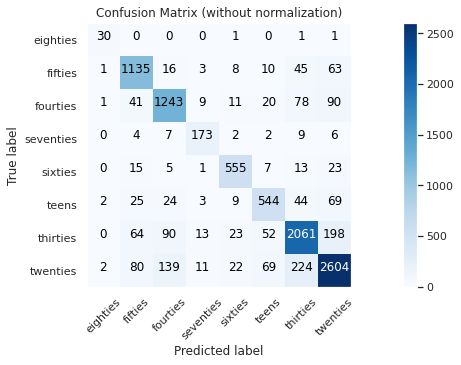

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

model = SVC(C=100, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
my_plot_confusion_matrix(cm, classes=classes)

plt.grid(False)
plt.show()

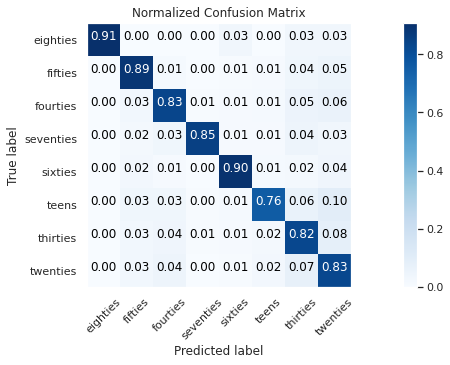

In [27]:
# Plot normalized confusion matrix
plt.figure()
my_plot_confusion_matrix(cm, classes=classes, normalize=True)

plt.grid(False)
plt.show()



In [ ]:
import joblib
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)